In [2]:
import mglearn
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
from sklearn.model_selection import train_test_split
import scipy as scipy
import seaborn as sns

# The data

In [3]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()

In [4]:
print("The keys of the object: {}".format(cancer.keys()))

The keys of the object: dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])


Data description

In [4]:
print(cancer['DESCR'][:3000])

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

:Number of Instances: 569

:Number of Attributes: 30 numeric, predictive attributes and the class

:Attribute Information:
    - radius (mean of distances from center to points on the perimeter)
    - texture (standard deviation of gray-scale values)
    - perimeter
    - area
    - smoothness (local variation in radius lengths)
    - compactness (perimeter^2 / area - 1.0)
    - concavity (severity of concave portions of the contour)
    - concave points (number of concave portions of the contour)
    - symmetry
    - fractal dimension ("coastline approximation" - 1)

    The mean, standard error, and "worst" or largest (mean of the three
    worst/largest values) of these features were computed for each image,
    resulting in 30 features.  For instance, field 0 is Mean Radius, field
    10 is Radius SE, field 20 is Worst Radius.

    - 

Divide the data into training and test

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, stratify=cancer.target, random_state=42)

## Learn and evaluate the model

In [6]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

Making predictions for a single instance

In [7]:
pd.DataFrame([X_test[0,:]], columns=cancer.feature_names)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,12.75,16.7,82.51,493.8,0.1125,0.1117,0.0388,0.02995,0.212,0.06623,...,14.45,21.74,93.63,624.1,0.1475,0.1979,0.1423,0.08045,0.3071,0.08557


In [8]:
print("Predicted class probabilities tree: {}".format(tree.predict_proba([X_test[0,:]])))

Predicted class probabilities tree: [[0. 1.]]


In [9]:
print("Accuracy on test set: {:.3f}".format(tree.score(X_test, y_test)))

Accuracy on test set: 0.923


##  Inspecting and analyzing the model

### Feature importance

In [10]:
print("Feature importances:\n{}".format(tree.feature_importances_))

Feature importances:
[0.00752597 0.         0.         0.         0.         0.
 0.00668975 0.01354675 0.         0.         0.         0.04630969
 0.         0.01206867 0.00238745 0.         0.         0.
 0.         0.         0.69546322 0.06135808 0.         0.00903116
 0.         0.         0.01740312 0.11684357 0.01137258 0.        ]


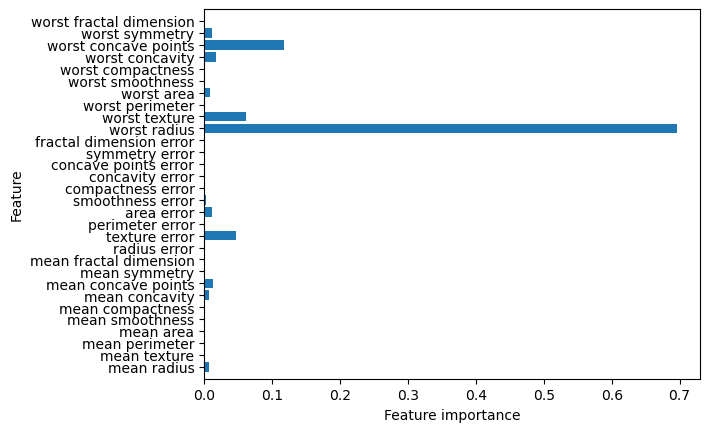

In [11]:
def plot_feature_importances_cancer(model):
    n_features = cancer.data.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), cancer.feature_names)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)
    plt.show()

plot_feature_importances_cancer(tree)

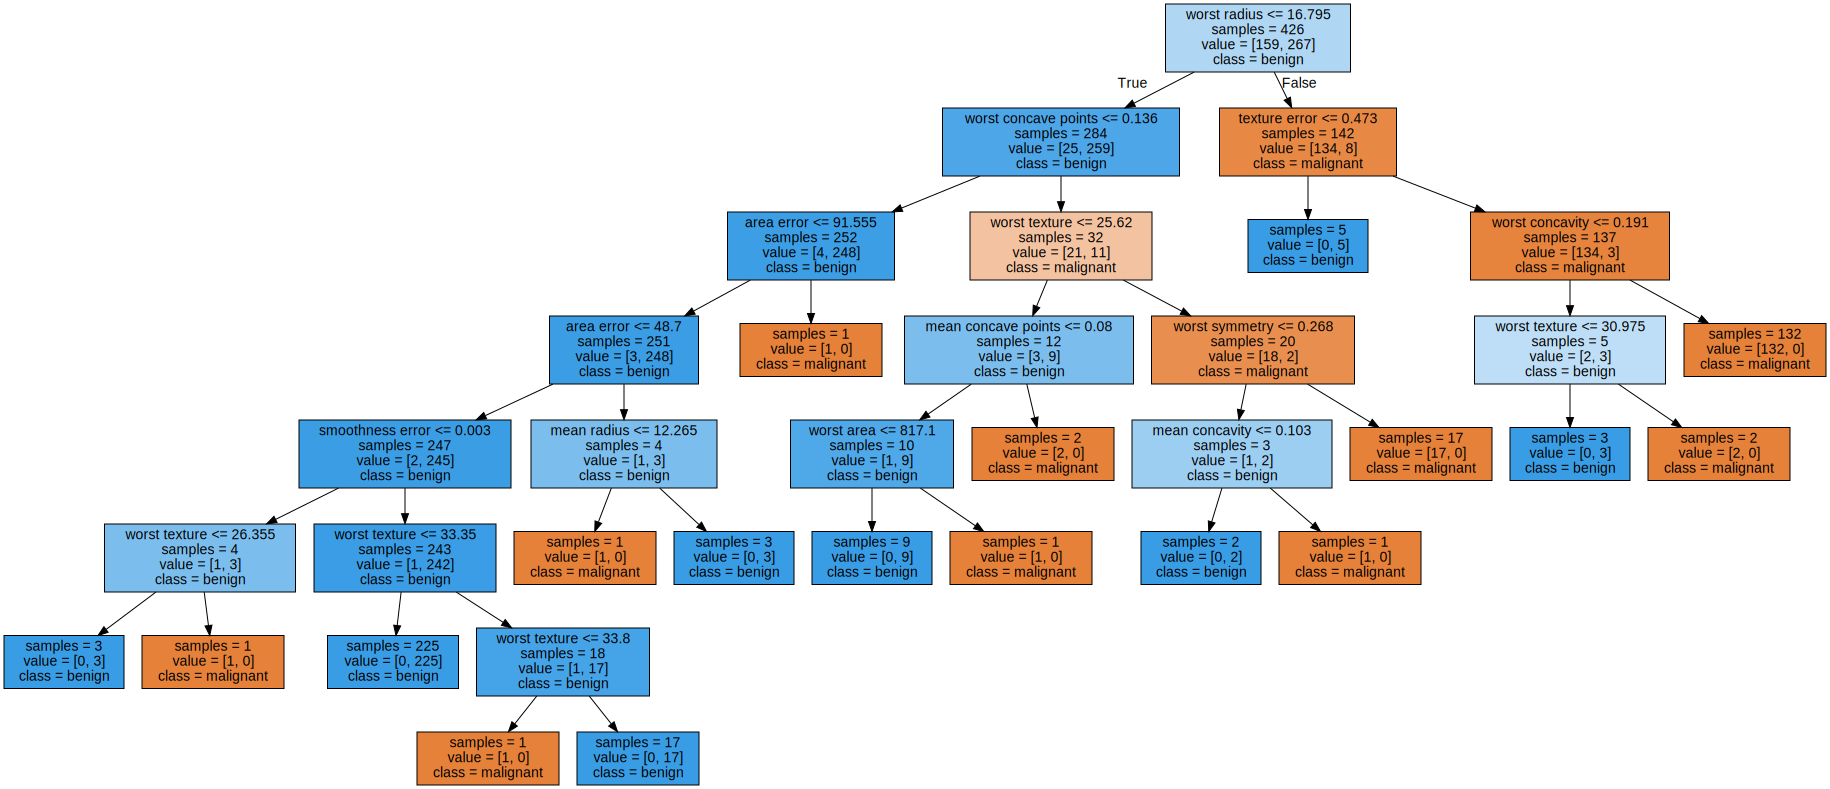

In [27]:
!pip install graphviz
from sklearn.tree import export_graphviz
import graphviz
export_graphviz(tree, out_file="tree.dot", class_names=["malignant", "benign"],
                feature_names=cancer.feature_names, impurity=False, filled=True)

with open("tree.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

## Controlling model size

The tree built above is relatively complex with all leaves being pure or close to pure. This also means that the tree will perform well on instances it has seen before, but not so well on new instances (it does a poor job at generalizing). We can see this by comparing the score on the training data and the test data.

In [ ]:
print("Accuracy on test data: {}".format(tree.score(X_test, y_test)))
print("Accuracy on training data: {}".format(tree.score(X_train, y_train)))

One way to mitigate this effect is to control the size of the decision tree so that it does not become overly complex. We can do this by specifying:
* max_depth
* min_samples_split
* min_samples_leaf 

In [ ]:
tree = DecisionTreeClassifier(min_samples_split=25, random_state=42)
tree.fit(X_train, y_train)
print("Accuracy on test data: {}".format(tree.score(X_test, y_test)))
print("Accuracy on training data: {}".format(tree.score(X_train, y_train)))

### Displaying the newly learned model

In [ ]:
export_graphviz(tree, out_file="tree.dot", class_names=["malignant", "benign"],
                feature_names=cancer.feature_names, impurity=False, filled=True)

with open("tree.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

# Encoding categorical variables

### The data from the slides

In [ ]:
df = pd.read_csv('DT-toy.csv')
X = df.iloc[:,0:-1].values
y = df.iloc[:,-1].values
display(df)

Unfortunately, `sklearn` does not currently support categorical feature variables, but only numerical features. We therefore need to massage the data to get it into our framework. Specifically, we will make a so-called *one-hot encoding* of each of the variables.
* Example: The `Outlook` variable is transformed into three binary variables that can either be `true` or `false`:
    - `Outlook=overcast`
    - `Outlook=rain`
    - `Outlook=sunny`

In [ ]:
# First we separate the data into features and target
df_feature_data = df.iloc[:,:-1]
df_target_data = df.iloc[:,-1]

# Next make an equivalent dictionary representation of the data over the features
dic = df_feature_data.T.to_dict().values()
print(dic)

### First the data over the feature variables

Using `sklearn`'s `DictVectorizer` we can convert this data to a one-hot-encoded form 

In [ ]:
from sklearn.feature_extraction import DictVectorizer
vec = DictVectorizer()
vec_data = vec.fit_transform(dic).toarray()
print("The newly constructed features:\n")
print(vec.feature_names_)
print("The associated binary data:\n")
print(vec_data)

### Next the target variable

This is much simpler

In [ ]:
df_target_data.replace('yes','1',inplace=True)
df_target_data.replace('no','0',inplace=True)
df_target_data

## Now we are finally ready to learn a model

In [ ]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(random_state=42)
tree.fit(vec_data, df_target_data.values)

And get some insights by visualizing it ...

In [ ]:
from sklearn.tree import export_graphviz
export_graphviz(tree, out_file="tree.dot", class_names=["no", "yes"],
                feature_names=vec.feature_names_, impurity=False, filled=True)

In [ ]:
import graphviz

with open("tree.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))